In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, RepeatedKFold, GridSearchCV

In [86]:
data_raw = pd.read_csv('Zillow-Scraper-results_1600_2024-11-06.csv')
data_raw = data_raw[['Status Text', 'Time On Zillow', 'Price', 'Area', 'Price Per Sqft', 
             'Lot Area', 'Lot Area Unit', 'Beds', 'Bathrooms', 'Address', 'Street', 'City', 'State', 'Zipcode', 'Latitude', 'Longitude'
]]
data_raw.head()

,Status Text,Time On Zillow,Price,Area,Price Per Sqft,Lot Area,Lot Area Unit,Beds,Bathrooms,Address,Street,City,State,Zipcode,Latitude,Longitude
0,Condo for sale,5 days,528000,1098.0,481.0,2815.0,sqft,2.0,2.0,"1511 Hilo St, West Covina, CA 91792",1511 Hilo St,West Covina,CA,91792,34.042397,-117.91430
1,Condo for sale,3 days,540000,1137.0,475.0,1137.0,sqft,2.0,2.0,"6525 Twin Circle Ln UNIT 7, Simi Valley, CA 93063",6525 Twin Circle Ln UNIT 7,Simi Valley,CA,93063,34.266700,-118.66285
2,Condo for sale,4 days,539000,1104.0,488.0,NaN,NaN,2.0,2.0,"675 Oak Run Trl UNIT 301, Oak Park, CA 91377",675 Oak Run Trl UNIT 301,Oak Park,CA,91377,34.184055,-118.76704
3,Condo for sale,27 days,555000,867.0,640.0,NaN,NaN,3.0,1.0,"16923 Cedarwood Ct, Cerritos, CA 90703",16923 Cedarwood Ct,Cerritos,CA,90703,33.877530,-118.06723
4,House for sale,4 days,725000,1015.0,714.0,2063.0,sqft,3.0,2.0,"1610 E 61st St, Long Beach, CA 90805",1610 E 61st St,Long Beach,CA,90805,33.865410,-118.17316


In [87]:
# filter and process data
# status text starts with Home House or Townhouse
data = data_raw[data_raw['Status Text'].str.contains('Home|House|Townhouse', na=False)].copy()
# remove ' days' from Time On Zillow and store as int
data['Time On Zillow'] = data['Time On Zillow'].str.replace(' days', '').astype(int)
# if lot area unit is acres, convert to sqft
data['Lot Area'] = np.where(data['Lot Area Unit'] == 'acres', data['Lot Area']*43560, data['Lot Area'])
# drop rows with missing values
data = data.dropna()
data.head()

,Status Text,Time On Zillow,Price,Area,Price Per Sqft,Lot Area,Lot Area Unit,Beds,Bathrooms,Address,Street,City,State,Zipcode,Latitude,Longitude
4,House for sale,4,725000,1015.0,714.0,2063.000,sqft,3.0,2.0,"1610 E 61st St, Long Beach, CA 90805",1610 E 61st St,Long Beach,CA,90805,33.865410,-118.173160
6,House for sale,4,2795000,3247.0,861.0,5702.004,sqft,5.0,5.0,"3843 Minerva Ave, Los Angeles, CA 90066",3843 Minerva Ave,Los Angeles,CA,90066,34.008743,-118.421715
7,House for sale,3,3300000,2409.0,1370.0,5083.452,sqft,4.0,4.0,"1611 Sunset Plaza Dr, Los Angeles, CA 90069",1611 Sunset Plaza Dr,Los Angeles,CA,90069,34.100456,-118.380974
9,House for sale,3,675000,1287.0,524.0,5606.172,sqft,2.0,1.0,"6030 Lemon Ave, Long Beach, CA 90805",6030 Lemon Ave,Long Beach,CA,90805,33.864280,-118.178910
12,House for sale,5,1475000,1948.0,757.0,6600.000,sqft,4.0,3.0,"16821 Montclair Ln, Huntington Beach, CA 92647",16821 Montclair Ln,Huntington Beach,CA,92647,33.718277,-117.984270


<Axes: ylabel='Price Per Sqft'>

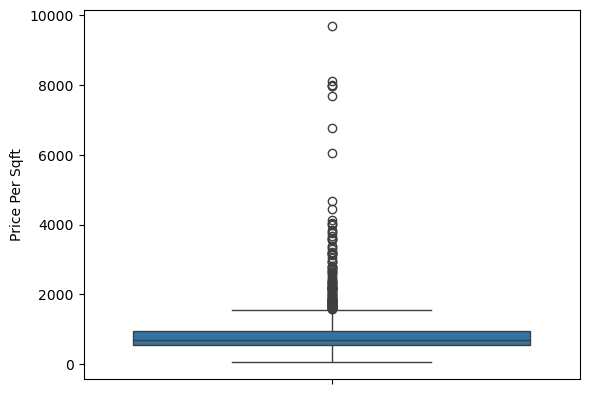

In [88]:
# check for outliers
sns.boxplot(data['Price Per Sqft'])

<Axes: ylabel='Price Per Sqft'>

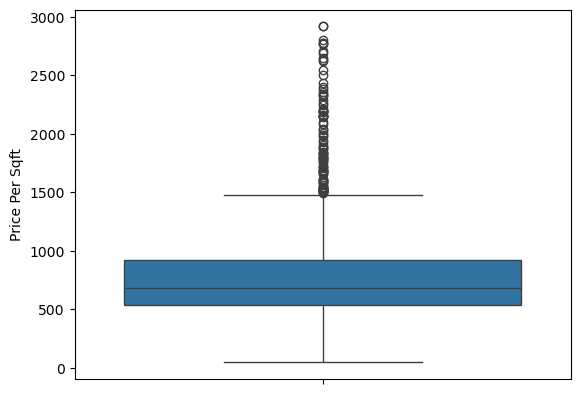

In [89]:
# remove outliers more than 2.5 standard deviations from the mean
data = data[np.abs(data['Price Per Sqft']-data['Price Per Sqft'].mean()) <= (2.5*data['Price Per Sqft'].std())]
sns.boxplot(data['Price Per Sqft'])

In [90]:
# replace column names with lowercase and underscores
data.columns = data.columns.str.lower().str.replace(' ', '_')

In [91]:
# split training and testing data
from sklearn.model_selection import train_test_split
x_col = ['Time On Zillow', 'Area', 'Lot Area', 'Beds', 'Bathrooms', 'Latitude', 'Longitude']
x_col = [col.lower().replace(' ', '_') for col in x_col]
y_col = 'Price Per Sqft'.lower().replace(' ', '_')
# y_col = 'Price'
X = data[x_col]
y = data[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [92]:
# train model using lightgbm
import lightgbm as lgb
model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# get mae, mse, r2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae:.3f}, MSE: {mse:.3f}, R2: {r2:.3f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1116
[LightGBM] [Info] Number of data points in the train set: 964, number of used features: 7
[LightGBM] [Info] Start training from score 797.390041
MAE: 224.042, MSE: 117852.383, R2: 0.477


<BarContainer object of 7 artists>

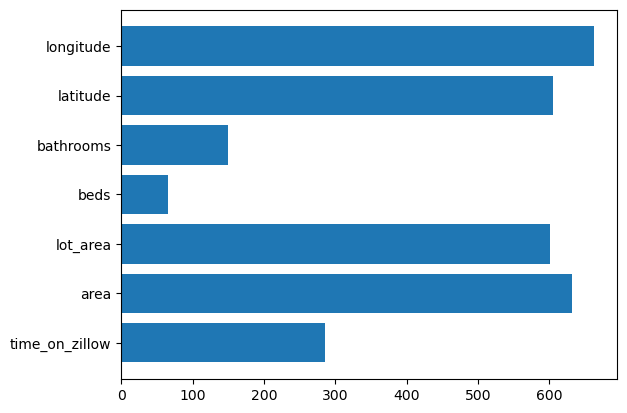

In [93]:
# model feature importance
feature_importance = model.feature_importances_
# show plot of feature importance
plt.barh(x_col, feature_importance)

In [94]:
# read in census data
census_data = pd.read_csv('census_data_cleaned.csv')
x_col = ['zipcode', 'median_income', 'population', 'households', 'housing_units',
       'homeowner_vacancy_rate', 'rental_vacancy_rate',
       'occupied_housing_units', 'median_rooms',
       'median_rent', 'median_value', 'value_to_income']
# left joint to data on zipcode
data_combined = data.merge(census_data[x_col], how='left', on='zipcode')

In [95]:
data_combined.columns

Index(['status_text', 'time_on_zillow', 'price', 'area', 'price_per_sqft',
       'lot_area', 'lot_area_unit', 'beds', 'bathrooms', 'address', 'street',
       'city', 'state', 'zipcode', 'latitude', 'longitude', 'median_income',
       'population', 'households', 'housing_units', 'homeowner_vacancy_rate',
       'rental_vacancy_rate', 'occupied_housing_units', 'median_rooms',
       'median_rent', 'median_value', 'value_to_income'],
      dtype='object')

In [96]:
# count number of missing values
data_combined.isnull().sum()
# drop rows with missing values
data_combined = data_combined.dropna()

In [97]:
# split training and testing data
x_col = ['time_on_zillow', 'area', 
       'lot_area', 'beds', 'bathrooms', 'latitude', 'longitude', 'median_income',
       'population', 'households', 'housing_units', 'homeowner_vacancy_rate',
       'rental_vacancy_rate', 'occupied_housing_units', 'median_rooms',
       'median_rent', 'median_value', 'value_to_income']
y_col = 'price_per_sqft'
X = data_combined[x_col]
y = data_combined[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
# train model using lightgbm
model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# get mae, mse, r2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae:.3f}, MSE: {mse:.3f}, R2: {r2:.3f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2889
[LightGBM] [Info] Number of data points in the train set: 857, number of used features: 18
[LightGBM] [Info] Start training from score 720.192532
MAE: 126.796, MSE: 31906.960, R2: 0.584


<BarContainer object of 18 artists>

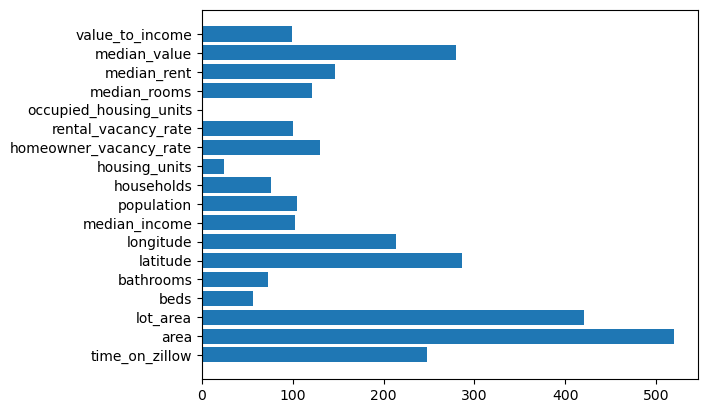

In [99]:
# model feature importance
feature_importance = model.feature_importances_
# show plot of feature importance
plt.barh(x_col, feature_importance)